# Double DQN implementation for Unity banana navigator

---

We begin by importing some necessary packages. 
- [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) 
- [NumPy](http://www.numpy.org/)
- [PyTorch](https://pytorch.org/)
- [matplotlib](https://matplotlib.org/)

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
from agent import Agent
import matplotlib.pyplot as plt

# This is optional.
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Check the python and module version.

In [2]:
"""
Python=3.6
torch=0.4.1
numpy=1.14.5
matplotlib=2.2.3
"""
!python --version
!pip freeze | grep torch
!pip freeze | grep numpy
!pip freeze | grep matplotlib

Python 3.6.6 :: Anaconda, Inc.


torch==0.4.1
numpy==1.14.5
matplotlib==2.2.3


### Load the environment

In [3]:
# change the path depending on your machine.
file_path = "Banana_Windows_x86_64/Banana.exe"
env = UnityEnvironment(file_name=file_path, seed=123)

# get the default brain
brain_name = env.brain_names[0]
env_info = env.reset(train_mode=True)[brain_name]
brain = env.brains[brain_name]
n_action = brain.vector_action_space_size
state = env_info.vector_observations[0]
dim_state = len(state)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Training Double DQN agent

We will train our agent using double Deep Q-Network algorithm. The DQN algorithm is based on Q-learning and use deep neural network architecture for Q-value function approximation. The agent you will import have following architecture:
- __Input layer__ : 37 dimension, i.e, dimension size of state space
- __Fully connected layer__ followed __ReLU__ activation function : 128 nodes
- __Fully connected layer__ followed __ReLU__ activation function : 128 nodes
- __Output layer__ : 4 dimension, i.e, dimension size of action space


In addition, double DQN algorithm have two characteristics, __target network__ and __experience replay__.

- __Target network__ : There are two value functions using neural network in DQN agent. The two value functions have same architecture, but have difference weights. One set of weights is used to determine the greedy policy and the other to determine its value. Target value is written as:<br><br>$Y^{DoubleDQN} = R_{t+1} + \gamma Q(s_{t+1}, \underset{a}{\operatorname{argmax}} Q(s_{t+1},a; \theta_{t}); \theta^{-}_{t})$<br>
where:<br><br>
$R_{t+1}$ : rewards<br>
$\gamma$ : discount factor<br>
$s_{t+1}$ : next state<br>
$a$ : action<br>
$\theta_{t}$ : the weights of online network for determination of the value<br>
$\theta^{-}_{t}$ : the weights of target network for evaluation of the current greedy policy<br><br>
The idea  is to reduce overestimations by decomposing the max operation in the target into action selection and action evaluation.

- __Experience replay__ : For the experience replay (Lin, 1992), observed transitions are stored for some time and sampled uniformly from this memory bank to update the network. By using experience replay, we can prevent harmful correlations of transitions, and experience replay allows us to learn more from individual tuples multiple times, recall rare occurrences, and in general make better use of our experience.

In [4]:
def dqn(n_episodes=10, max_t=100, eps_start=1.0, eps_end=1e-2, \
        eps_decay=0.995, print_every=100, seed=77):
    """
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            # select an action and extract state from env
            action = agent.act(state, eps)
            env_info = env.step(vector_action=int(action))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            # take the action
            agent.step(state, action, reward, next_state, done)
            # add reward to score
            score += reward
            # save state
            state = next_state
            if done:
                break
        # save results
        scores.append(score)
        scores_window.append(score)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % print_every == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 100.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_online.state_dict(), 'checkpoint.pth')
            break
        
    return scores

start training.

Episode 100	Average Score: 0.30
Episode 200	Average Score: 3.68
Episode 300	Average Score: 7.28
Episode 400	Average Score: 10.78
Episode 500	Average Score: 13.32
Episode 600	Average Score: 13.34
Episode 700	Average Score: 12.93
Episode 800	Average Score: 14.46
Episode 900	Average Score: 14.21
Episode 1000	Average Score: 13.73


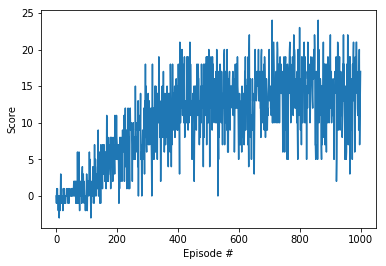

In [5]:
random_seed = 123
agent = Agent(dim_state=dim_state, n_action=n_action, seed=random_seed)
scores = dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=1e-2, eps_decay=0.995, \
            print_every=100, seed=random_seed)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env.close()